# Code Description
This code takes the large output of a parameter estimation project and then post-processes all of the data

Functions use a standard indexing to refer to our 4 parameters: 0 index is c1, 1 is c2, 2 is T21, and 3 is T22

All parameter sets will be loaded in through the summary file associated with the result files

This code was initially written by Ryan Neff and then continued by Griffin Hampton (GSH) - Mirage Modi played a very important role in the multiprocessing of the data

# Import Packages

In [115]:
#%matplotlib widget
import scipy
import scipy.io
from scipy.optimize import curve_fit
from scipy.optimize import least_squares
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib import colors
import numpy as np
import statistics
import math
import time
import itertools
import colorsys
from tqdm import trange
from datetime import date
import pickle
import pandas as pd
from matplotlib.patches import Patch
import os

# Options

In [116]:
post_normalized_data = True

if post_normalized_data:
    pn_file = 'postNorm'
else:
    pn_file = 'noNorm'

In [117]:
#Initial Trial Data is Stored on 17Jan23
d1_pat_id = 'BLSA_1935_06_MCIAD_m79'#'BLSA_1742_04_MCIAD_m41'
d1_pat_tag = d1_pat_id[-3:]
d1_slice_num = 3
d1_target_SNR = 75
d1_data_date_oi = '25Apr24'
d1_process_date_oi = '06May24'

d1_data_folder = f"{d1_pat_tag}_slice{d1_slice_num}_SNR_{d1_target_SNR}_BIC_filter_{d1_data_date_oi}"
d1_analysis_file = f"{pn_file}_{d1_process_date_oi}"

In [118]:
#Initial Trial Data is Stored on 17Jan23
d2_pat_id = 'BLSA_1935_06_MCIAD_m79'#'BLSA_1742_04_MCIAD_m41'
d2_pat_tag = d2_pat_id[-3:]
d2_slice_num = 5
d2_target_SNR = 75
d2_data_date_oi = '25Apr24'
d2_process_date_oi = '26Apr24'

d2_data_folder = f"{d2_pat_tag}_slice{d2_slice_num}_SNR_{d2_target_SNR}_BIC_filter_{d2_data_date_oi}"
d2_analysis_file = f"{pn_file}_{d2_process_date_oi}"

In [119]:
#Initial Trial Data is Stored on 17Jan23
d3_pat_id = 'BLSA_1935_06_MCIAD_m79'#'BLSA_1935_06_MCIAD_m79'
d3_pat_tag = d3_pat_id[-3:]
d3_slice_num = 8
d3_target_SNR = 75
d3_data_date_oi = '25Apr24'
d3_process_date_oi = '06May24'

d3_data_folder = f"{d3_pat_tag}_slice{d3_slice_num}_SNR_{d3_target_SNR}_BIC_filter_{d3_data_date_oi}"
d3_analysis_file = f"{pn_file}_{d3_process_date_oi}"

# Signal Functions

In [120]:
def G_biX_off(t, con_1, con_2, tau_1, tau_2, offSet): 
    signal = con_1*np.exp(-t/tau_1) + con_2*np.exp(-t/tau_2) + offSet
    return signal

def G_moX_off(t, con, tau, offSet): 
    signal = con*np.exp(-t/tau) + offSet
    return signal

# Define Parameters

In [121]:
def load_results(pat_id, data_folder, analysis_file): 
    file_path = f'Intermediate_ExpResults/{pat_id}/{data_folder}/{analysis_file}.pkl'

    if os.path.isfile(file_path):
        with open(file_path, 'rb') as handle:
            dict = pickle.load(handle)
            data_hyperParam = dict['HyperParams_exp']
            gs_BIC_choices = dict['gs_BIC_region']
            gs_nonreg_estimates = dict['gs_nonreg_est']
            exp_BIC_region = dict['exp_BIC_region']
            nonreg_estimates = dict['exp_nonreg_est']
            GCV_estimates = dict['exp_GCV_est']

            handle.close()

    else:
        raise ValueError(f'There is not a valid results files to load. Check path:{file_path}')

    file_path = data_hyperParam

    if os.path.isfile(file_path):
        with open(file_path, 'rb') as handle:
            dict = pickle.load(handle)
            mask_shape = dict['mask_shape']
            SNR_folder = dict['SNR_info_folder']
            slice_num = dict["data_slice"]
    else:
        raise ValueError(f'Underlying file missing. Check path:{file_path}')
    
    file_path = SNR_folder

    if os.path.isfile(file_path):
        with open(file_path, 'rb') as handle:
            dict = pickle.load(handle)
            sigma_SNR = dict['SNR']
            handle.close()
        
    else:
        raise ValueError(f'Underlying file missing. Check path:{file_path}')

    print(f'Data loaded in for slice {slice_num} of {pat_id[-3:]}')
    print(f'SNR of original brain sigma slice = {sigma_SNR:.2f}')
    
    p_est_mat = [gs_nonreg_estimates, nonreg_estimates, GCV_estimates]
    strux_mat = [mask_shape, exp_BIC_region, gs_BIC_choices]
    
    return p_est_mat, strux_mat, sigma_SNR

In [122]:
d1_p_est_mat, d1_strux_mat, d1_SNR = load_results(d1_pat_id, d1_data_folder, d1_analysis_file)
d2_p_est_mat, d2_strux_mat, d2_SNR = load_results(d2_pat_id, d2_data_folder, d2_analysis_file)
d3_p_est_mat, d3_strux_mat, d3_SNR = load_results(d3_pat_id, d3_data_folder, d3_analysis_file)

###################### Parameters Loop Through

param_name_list = [r'$c_1$',r'$c_2$',r'$T_{21}$',r'$T_{22}$']

##################### Important for Naming
date = date.today()
day = date.strftime('%d')
month = date.strftime('%B')[0:3]
year = date.strftime('%y')

Data loaded in for slice 3 of m79
SNR of original brain sigma slice = 102.19


Data loaded in for slice 5 of m79
SNR of original brain sigma slice = 102.19
Data loaded in for slice 8 of m79
SNR of original brain sigma slice = 102.19


# Define General Functions

### Small Helper Functions

In [123]:
def calc_improvement(old, new):
    return (old - new)/old

def get_brain_outline(raw):
    n_vert = raw.shape[0]
    n_hori = raw.shape[1]
    I_outline = np.zeros((n_vert, n_hori))
    for i_vert in range(n_vert):
        for i_hori in range(n_hori):
            try:
                init_sig = raw[i_vert, i_hori]
                if i_vert > 0:
                    init_sig_up = raw[i_vert-1, i_hori]
                else:
                    init_sig_up = 0
                if i_vert < n_vert - 1:
                    init_sig_dn = raw[i_vert+1, i_hori]
                else:
                    init_sig_dn = 0
                if i_hori > 0:
                    init_sig_lt = raw[i_vert, i_hori - 1]
                else:
                    init_sig_lt = 0
                if i_hori < n_hori - 1:
                    init_sig_rt = raw[i_vert, i_hori + 1]
                else:
                    init_sig_up = 0
                surround = [init_sig_up, init_sig_dn, init_sig_lt, init_sig_rt]
                if np.sum(surround) >0 and init_sig == 0:
                    I_outline[i_vert,i_hori] = 1
            except:
                I_outline[i_vert,i_hori] = np.nan
    return I_outline

def _get_colors(num_colors):
    colors = []
    for i in np.arange(0., 360., 360. / num_colors):
        hue = i/360.
        lightness = (50 + np.random.rand() *10)/100.
        saturation = (90 + np.random.rand() * 10)/100.
        colors.append(colorsys.hls_to_rgb(hue, lightness, saturation))
    return colors

# Images

In [124]:
brain_outline = get_brain_outline(d1_strux_mat[0])
d1_outline_indices = np.where(brain_outline == 1)

brain_outline = get_brain_outline(d2_strux_mat[0])
d2_outline_indices = np.where(brain_outline == 1)

brain_outline = get_brain_outline(d3_strux_mat[0])
d3_outline_indices = np.where(brain_outline == 1)

### BIC Regions

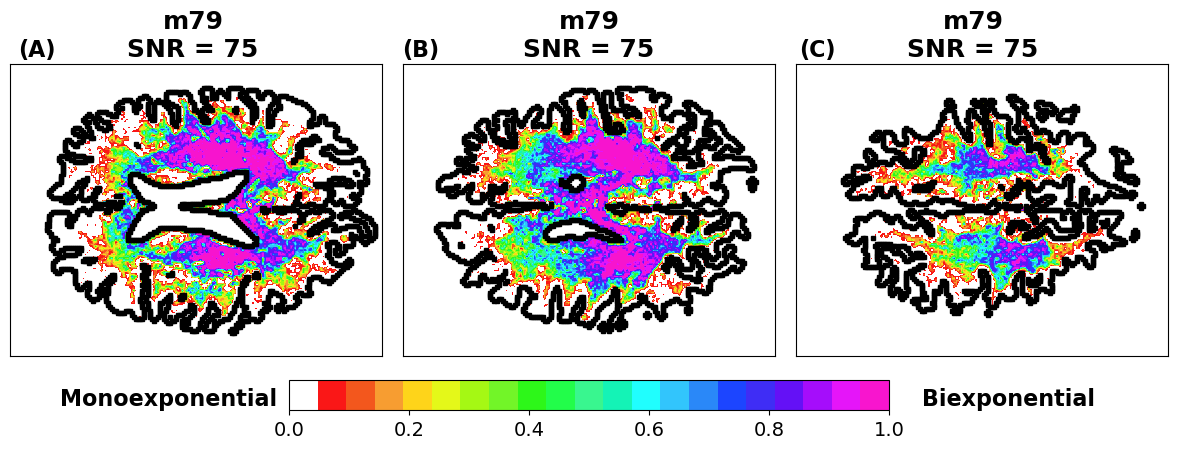

In [125]:
gen_colors = [(1,1,1)] + _get_colors(d1_p_est_mat[1].shape[0]+2)
BiX_freq_cmap = colors.ListedColormap(gen_colors[:-2])

fig, ax = plt.subplots(1,3, figsize=(12,5),tight_layout=True)

# plt.rc('font', size = 18)
# fig.suptitle('Frequency of Voxels Labeled as Biexponential by BIC\nAcross Noise Realizations', y=0.95)

plt.rc('font', size = 14)

BIC = ax[0].imshow(np.sum(d1_strux_mat[1], axis = 0)/d1_strux_mat[1].shape[0], cmap = BiX_freq_cmap, vmin = 0, vmax = 1)
ax[0].plot(d1_outline_indices[1], d1_outline_indices[0], color = 'k', marker = 's', ls = '', markersize = 2.5)
# ax[0].set_title(f'{d1_pat_tag} :: SNR = {d1_target_SNR}')
ax[0].tick_params(left = False, bottom = False, labelbottom = False, labelleft = False)

BIC = ax[1].imshow(np.sum(d2_strux_mat[1], axis = 0)/d2_strux_mat[1].shape[0], cmap = BiX_freq_cmap, vmin = 0, vmax = 1)
ax[1].plot(d2_outline_indices[1], d2_outline_indices[0], color = 'k', marker = 's', ls = '', markersize = 2.5)
# ax[1].set_title(f'{d1_pat_tag} :: SNR = {d2_target_SNR}')
ax[1].tick_params(left = False, bottom = False, labelbottom = False, labelleft = False)

BIC = ax[2].imshow(np.sum(d3_strux_mat[1], axis = 0)/d3_strux_mat[1].shape[0], cmap = BiX_freq_cmap, vmin = 0, vmax = 1)
ax[2].plot(d3_outline_indices[1], d3_outline_indices[0], color = 'k', marker = 's', ls = '', markersize = 2.5)
# ax[2].set_title(f'{d3_pat_tag} :: SNR = {d3_target_SNR}')
ax[2].tick_params(left = False, bottom = False, labelbottom = False, labelleft = False)

cb_ax = fig.add_axes([0.25,0.1,0.5,.06])
fig.colorbar(BIC, orientation = 'horizontal', cax=cb_ax)
plt.rc('font', size  = 16)
fig.text(0.15, 0.11,"Monoexponential", ha='center', weight = 'bold')
fig.text(0.85, 0.11,"Biexponential", ha='center', weight = 'bold')

plt.rc('font', size = 18)
fig.text(0.17,0.85,f'{d1_pat_tag}\nSNR = {d1_target_SNR}', weight = 'bold', ha="center", va="center")
fig.text(0.50,0.85,f'{d2_pat_tag}\nSNR = {d2_target_SNR}', weight = 'bold', ha="center", va="center")
fig.text(0.82,0.85,f'{d3_pat_tag}\nSNR = {d3_target_SNR}', weight = 'bold', ha="center", va="center")

plt.rc('font', size = 16)
fig.text(0.04,0.82, '(A)', ha="center", va="center", color="black", weight = "bold")
fig.text(0.36,0.82, '(B)', ha="center", va="center", color="black", weight = "bold")
fig.text(0.69,0.82, '(C)', ha="center", va="center", color="black", weight = "bold")
plt.rc('font', size = 14)

### MWF Comparison Graphs

Average MWF, excluding >0.4, = 0.18116499991284693
Average MWF, excluding >0.4, = 0.11072648811170464
Average MWF, excluding >0.4, = 0.21202387464831166


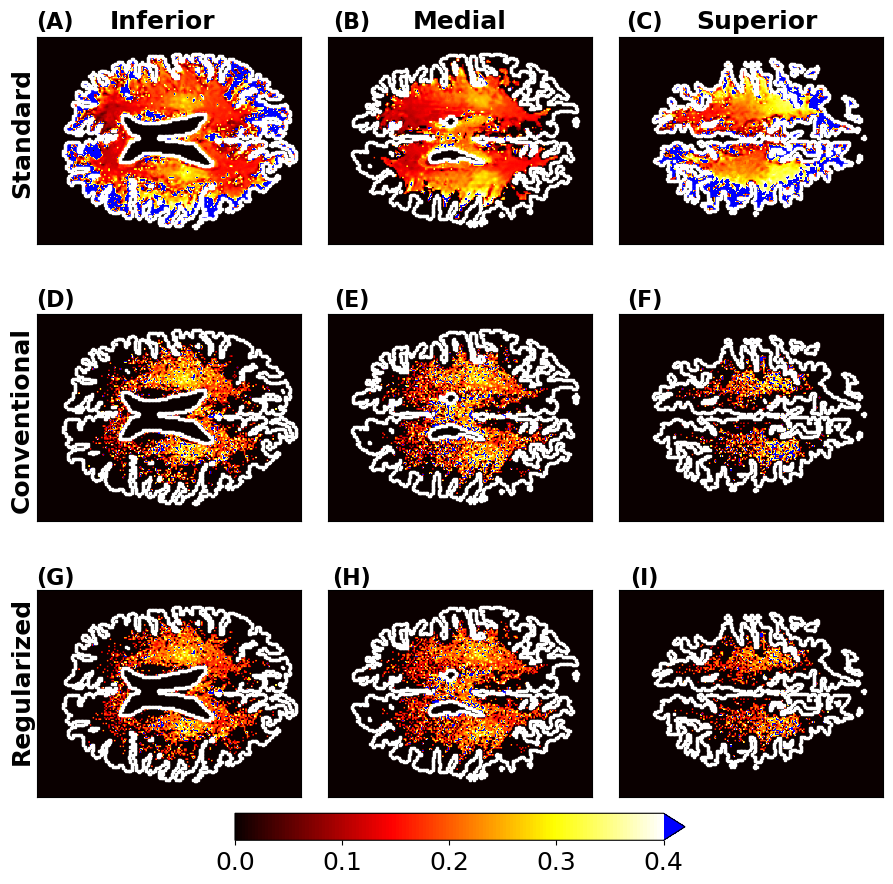

In [126]:
fig, ax = plt.subplots(3,3,figsize=(9,9),tight_layout=True)
plt.rc('font', size  = 16)

iter_oi = 0

MWF_cb_map = plt.get_cmap('hot', 128)
# stack_white = np.vstack(((1,0,0,0),MWF_cb_map(np.linspace(0,1,128))))
# MWF_cb_map = colors.ListedColormap(stack_white, name = 'MWF_cb_map')
MWF_cb_map.set_extremes(over = 'blue')
extend_opt = "max" #min, max, both, neither
upper_bound = 0.4

data_array = [d1_p_est_mat, d2_p_est_mat, d3_p_est_mat]
strux_array = [d1_strux_mat, d2_strux_mat, d3_strux_mat]
outline_array = [d1_outline_indices, d2_outline_indices, d3_outline_indices]

for iDat in range(len(data_array)):
    outline_indices = outline_array[iDat]
    data = data_array[iDat]
    BIC_region = strux_array[iDat][1][iter_oi,:,:]

    # fig.suptitle('Myelin Water Fraction (MWF) Maps' + '\nNoise Realization: '+ str(iter_oi+1) + ' :: SNR = ' + str(np.round(SNR_array[iter_oi],2)))
    imref = ax[0,iDat].imshow(data[0][:,:,0], cmap = MWF_cb_map, vmin = 0, vmax = upper_bound)
    # ax[0].set_title('Standard Reference')
    ax[0,iDat].tick_params(left = False, bottom = False, labelbottom = False, labelleft = False)
    ax[0,iDat].plot(outline_indices[1],outline_indices[0], color = 'w', marker = 's', ls = '', markersize = 1.5)

    imNLLS = ax[1,iDat].imshow(data[1][iter_oi,:,:,0]*BIC_region, cmap = MWF_cb_map, vmin=0, vmax=upper_bound)
    # ax[1].set_title('Nonregularized NLLS')
    ax[1,iDat].tick_params(left = False, bottom = False, labelbottom = False, labelleft = False)
    ax[1,iDat].plot(outline_indices[1],outline_indices[0], color = 'w', marker = 's', ls = '', markersize = 1.5)

    imGCV = ax[2,iDat].imshow(data[2][iter_oi,:,:,0]*BIC_region, cmap = MWF_cb_map, vmin=0, vmax=upper_bound)
    # ax[2].set_title('Regularized NLLS')
    ax[2,iDat].tick_params(left = False, bottom = False, labelbottom = False, labelleft = False)
    ax[2,iDat].plot(outline_indices[1],outline_indices[0], color = 'w', marker = 's', ls = '', markersize = 1.5)

    MWF_standard = data[0][:,:,0]
    MWF_standard = MWF_standard[np.where(strux_array[iDat][0])]
    print(f"Average MWF, excluding >0.4, = {np.mean(MWF_standard[np.where(MWF_standard<upper_bound)])}")

plt.rc('font', size = 16)
fig.text(0.05,0.94, '(A)', ha="center", va="center", color="black", weight = "bold")
fig.text(0.38,0.94, '(B)', ha="center", va="center", color="black", weight = "bold")
fig.text(0.705,0.94, '(C)', ha="center", va="center", color="black", weight = "bold")
fig.text(0.05,0.63, '(D)', ha="center", va="center", color="black", weight = "bold")
fig.text(0.38,0.63, '(E)', ha="center", va="center", color="black", weight = "bold")
fig.text(0.705,0.63, '(F)', ha="center", va="center", color="black", weight = "bold")
fig.text(0.05,0.322, '(G)', ha="center", va="center", color="black", weight = "bold")
fig.text(0.38,0.322, '(H)', ha="center", va="center", color="black", weight = "bold")
fig.text(0.705,0.322, '(I)', ha="center", va="center", color="black", weight = "bold")

# plt.rc('font', size = 16)
# fig.text(0.05,0.94, '(A)', ha="center", va="center", color="black", weight = "bold")
# fig.text(0.38,0.94, '(B)', ha="center", va="center", color="black", weight = "bold")
# fig.text(0.705,0.94, '(X)', ha="center", va="center", color="black", weight = "bold")
# fig.text(0.05,0.63, '(C)', ha="center", va="center", color="black", weight = "bold")
# fig.text(0.38,0.63, '(D)', ha="center", va="center", color="black", weight = "bold")
# fig.text(0.705,0.63, '(X)', ha="center", va="center", color="black", weight = "bold")
# fig.text(0.05,0.322, '(E)', ha="center", va="center", color="black", weight = "bold")
# fig.text(0.38,0.322, '(F)', ha="center", va="center", color="black", weight = "bold")
# fig.text(0.705,0.322, '(X)', ha="center", va="center", color="black", weight = "bold")


plt.rc('font', size = 18)
# fig.text(0.17,0.95,f'{d1_pat_tag}\nSNR = {d1_SNR:.0f}', weight = 'bold', ha="center", va="center")
# fig.text(0.50,0.95,f'{d2_pat_tag}\nSNR = {d2_SNR:.0f}', weight = 'bold', ha="center", va="center")
# fig.text(0.82,0.95,f'{d3_pat_tag}\nSNR = {d3_SNR:.0f}', weight = 'bold', ha="center", va="center")
# fig.text(0.17,0.63,f'SNR = {d1_target_SNR}', weight = 'bold', ha="center", va="center")
# fig.text(0.50,0.63,f'SNR = {d2_target_SNR}', weight = 'bold', ha="center", va="center")
# fig.text(0.82,0.63,f'SNR = {d3_target_SNR}', weight = 'bold', ha="center", va="center")
# fig.text(0.17,0.322,f'SNR = {d1_target_SNR}', weight = 'bold', ha="center", va="center")
# fig.text(0.50,0.322,f'SNR = {d2_target_SNR}', weight = 'bold', ha="center", va="center")
# fig.text(0.82,0.322,f'SNR = {d3_target_SNR}', weight = 'bold', ha="center", va="center")
fig.text(0, 0.75 ,f'Standard', rotation = 'vertical', weight = 'bold')
fig.text(0, 0.40 ,f'Conventional', rotation = 'vertical', weight = 'bold')
fig.text(0, 0.12 ,f'Regularized', rotation = 'vertical', weight = 'bold')
plt.rc('font', size = 18)
fig.text(0.17,0.94,f'Inferior', weight = 'bold', ha="center", va="center")
fig.text(0.50,0.94,f'Medial', weight = 'bold', ha="center", va="center")
fig.text(0.83,0.94,f'Superior', weight = 'bold', ha="center", va="center")

cb_ax = fig.add_axes([0.25,0.03,0.5,.03])
fig.colorbar(imGCV, orientation = 'horizontal', cax=cb_ax, extend = extend_opt)

plt.show()

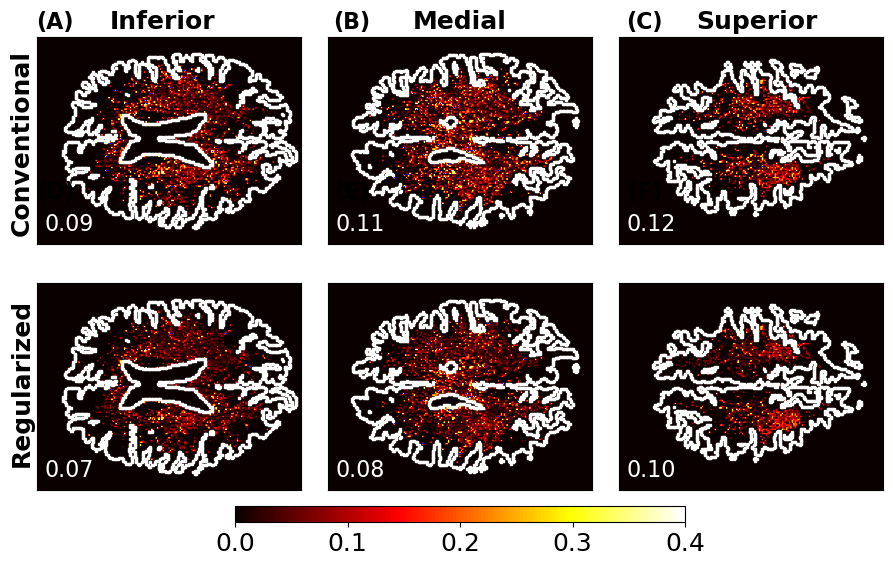

In [127]:
fig, ax = plt.subplots(2,3,figsize=(9,5.5),tight_layout=True)
plt.rc('font', size  = 16)

iter_oi = 0

MWF_cb_map = plt.get_cmap('hot', 128)
# stack_white = np.vstack(((1,0,0,0),MWF_cb_map(np.linspace(0,1,128))))
# MWF_cb_map = colors.ListedColormap(stack_white, name = 'MWF_cb_map')
MWF_cb_map.set_extremes(over = 'blue')
extend_opt = "max" #min, max, both, neither
upper_bound = 0.4

data_array = [d1_p_est_mat, d2_p_est_mat, d3_p_est_mat]
strux_array = [d1_strux_mat, d2_strux_mat, d3_strux_mat]
outline_array = [d1_outline_indices, d2_outline_indices, d3_outline_indices]

for iDat in range(len(data_array)):
    outline_indices = outline_array[iDat]
    data = data_array[iDat]
    BIC_region = strux_array[iDat][1][iter_oi,:,:]
    num_BIC = np.sum(BIC_region)

    abs_diff = np.abs(data[1][iter_oi,:,:,0] - data[0][:,:,0])*BIC_region
    imNLLS = ax[0,iDat].imshow(abs_diff, cmap = MWF_cb_map, vmin=0, vmax=upper_bound)
    ax[0,iDat].text(5,135,f'{1/num_BIC*(np.sum(abs_diff[np.where(BIC_region)])):.2f}', color = 'w')
    ax[0,iDat].tick_params(left = False, bottom = False, labelbottom = False, labelleft = False)
    ax[0,iDat].plot(outline_indices[1],outline_indices[0], color = 'white', marker = 's', ls = '', markersize = 1.5)

    abs_diff = np.abs(data[2][iter_oi,:,:,0]- data[0][:,:,0])*BIC_region
    imGCV = ax[1,iDat].imshow(abs_diff, cmap = MWF_cb_map, vmin=0, vmax=upper_bound)
    ax[1,iDat].text(5,135,f'{1/num_BIC*(np.sum(abs_diff[np.where(BIC_region)])):.2f}', color = 'w')
    ax[1,iDat].tick_params(left = False, bottom = False, labelbottom = False, labelleft = False)
    ax[1,iDat].plot(outline_indices[1],outline_indices[0], color = 'white', marker = 's', ls = '', markersize = 1.5)

plt.rc('font', size = 16)
fig.text(0.05,0.94, '(A)', ha="center", va="center", color="black", weight = "bold")
fig.text(0.38,0.94, '(B)', ha="center", va="center", color="black", weight = "bold")
fig.text(0.705,0.94, '(C)', ha="center", va="center", color="black", weight = "bold")
fig.text(0.05,0.63, '(D)', ha="center", va="center", color="black", weight = "bold")
fig.text(0.38,0.63, '(E)', ha="center", va="center", color="black", weight = "bold")
fig.text(0.705,0.63, '(F)', ha="center", va="center", color="black", weight = "bold")
plt.rc('font', size = 18)
# fig.text(0.17,0.96,f'{d1_pat_tag}\nSNR = {d1_target_SNR}', weight = 'bold', ha="center", va="center")
# fig.text(0.50,0.96,f'{d2_pat_tag}\nSNR = {d2_target_SNR}', weight = 'bold', ha="center", va="center")
# fig.text(0.82,0.96,f'{d3_pat_tag}\nSNR = {d3_target_SNR}', weight = 'bold', ha="center", va="center")
fig.text(0, 0.56 ,f'Conventional', rotation = 'vertical', weight = 'bold')
fig.text(0, 0.14 ,f'Regularized', rotation = 'vertical', weight = 'bold')
plt.rc('font', size = 18)
fig.text(0.17,0.94,f'Inferior', weight = 'bold', ha="center", va="center")
fig.text(0.50,0.94,f'Medial', weight = 'bold', ha="center", va="center")
fig.text(0.83,0.94,f'Superior', weight = 'bold', ha="center", va="center")

cb_ax = fig.add_axes([0.25,0.03,0.5,.03])
fig.colorbar(imGCV, orientation = 'horizontal', cax=cb_ax)

plt.show()

### MSE Composistion Maps

In [128]:
delta_txt = r'$\Delta$'

##### MWF Individual Noise Realizations

In [129]:
### Individual Plot Calculations

scan_num_list = []#np.arange(0,iterations,1)

list_NR_DRMSE = []

for scan_num in scan_num_list:

    new_diff = np.abs(GCV_estimates[scan_num,:,:,0] - gs_nonreg_estimates[:,:,0])
    old_diff = np.abs(nonreg_estimates[scan_num,:,:,0] - gs_nonreg_estimates[:,:,0])

    #Abbreviated as ACD
    absolute_comparative_diff = old_diff - new_diff
    ACDRange = 0.5#np.max(np.abs(absolute_comparative_diff))

    ACD_fullBrain = absolute_comparative_diff*exp_BIC_region[scan_num,:,:]

    num_vox = np.sum(exp_BIC_region[scan_num,:,:])

    indiv_brain_old = (1/num_vox*np.sum((nonreg_estimates[scan_num,:,:,0]*exp_BIC_region[scan_num,:,:] - gs_nonreg_estimates[:,:,0]*exp_BIC_region[scan_num,:,:])**2))**(1/2)
    indiv_brain_new = (1/num_vox*np.sum((GCV_estimates[scan_num,:,:,0]*exp_BIC_region[scan_num,:,:] - gs_nonreg_estimates[:,:,0]*exp_BIC_region[scan_num,:,:])**2))**(1/2)
    indiv_brain_meas = indiv_brain_old - indiv_brain_new
    
    fig, ax = plt.subplots(1,1,figsize=(5.5,6.5),tight_layout=True)
    plt.rc('font', size  = 20)
    delta_txt = r'$\Delta$'
    fig.suptitle(f'Individual Scan {delta_txt}RMSE in\nScan {scan_num+1} of {iterations} at SNR = {target_SNR}' )
    plt.rc('font', size  = 16)

    pNLLS = ax.imshow(ACD_fullBrain, cmap = 'seismic_r', vmin=-ACDRange, vmax = ACDRange)
    cbar = fig.colorbar(pNLLS, ax=ax, fraction=0.046, pad=0.04, location = 'bottom')
    ax.set_title(f'Full Brain {delta_txt}RMSE = {indiv_brain_meas:0.5f}')
    ax.tick_params(left = False, bottom = False, labelbottom = False, labelleft = False)
    ax.plot(outline_indices[1],outline_indices[0], color = 'k', marker = 's', ls = '', markersize = 1.5)

    plt.rc('font', size  = 14)
    fig.text(0.25, -0.05,"Nonregularized\nSuperior", ha='center')
    fig.text(0.75, -0.05,"Regularized\nSuperior", ha='center')


    plt.show()

    list_NR_DRMSE.append(indiv_brain_meas)

$\Delta$RMSE of MWF for Individual Noise Realizations for m79 at SNR = 102.19146093033449
Iteration 0 RMSE = 0.03075
Iteration 4 RMSE = 0.02920
Iteration 7 RMSE = 0.03012


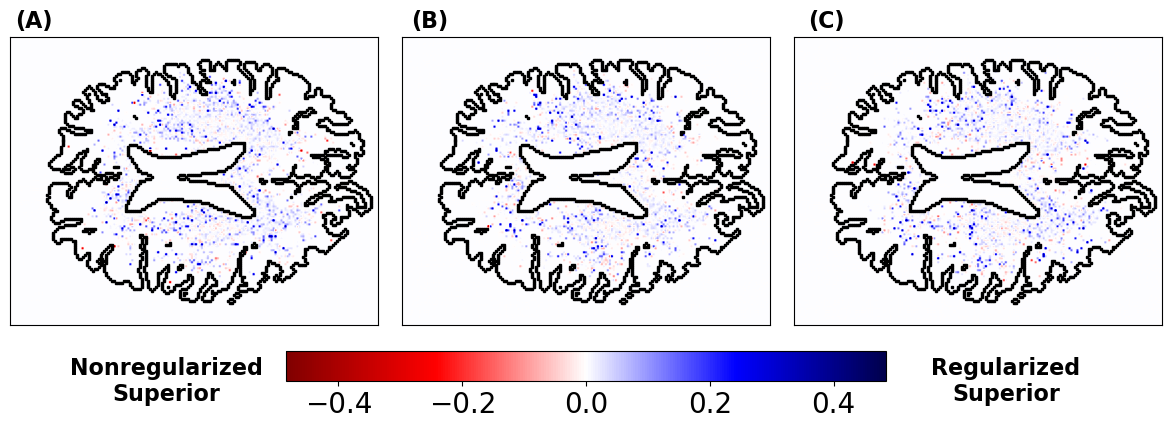

In [130]:
scan_num_list = [0,4,7]

hold_array = []
root_avg_square_change = []
max_array = []

delta_txt = r'$\Delta$'
fig, ax = plt.subplots(1,3,figsize=(12,5),tight_layout=True)
plt.rc('font', size  = 20)

for iScan in range(len(scan_num_list)):
    scan_num = scan_num_list[iScan]

    #Generates differences for each individual pixel
    new_diff = np.abs(d1_p_est_mat[-1][scan_num,:,:,0] - d1_p_est_mat[0][:,:,0])
    old_diff = np.abs(d1_p_est_mat[1][scan_num,:,:,0] - d1_p_est_mat[0][:,:,0])

    #Abbreviated as ACD
    absolute_comparative_diff = old_diff - new_diff
    hold_array.append(absolute_comparative_diff)
    max_array.append(np.max(np.abs(absolute_comparative_diff)))

    num_vox = np.sum(d1_strux_mat[1][scan_num,:,:])
    indiv_brain_old = (1/num_vox*np.sum(((d1_p_est_mat[1][scan_num,:,:,0] - d1_p_est_mat[0][:,:,0])*d1_strux_mat[1][scan_num,:,:])**2))**(1/2)
    indiv_brain_new = (1/num_vox*np.sum(((d1_p_est_mat[-1][scan_num,:,:,0] - d1_p_est_mat[0][:,:,0])*d1_strux_mat[1][scan_num,:,:])**2))**(1/2)
    indiv_brain_meas = indiv_brain_old - indiv_brain_new

    root_avg_square_change.append(indiv_brain_meas)


overall_max = np.max(max_array)
for iScan in range(len(scan_num_list)):
    pNLLS = ax[iScan].imshow(hold_array[iScan], cmap = 'seismic_r', vmin = -overall_max, vmax = overall_max)
    ax[iScan].tick_params(left = False, bottom = False, labelbottom = False, labelleft = False)
    ax[iScan].plot(d1_outline_indices[1],d1_outline_indices[0], color = 'k', marker = 's', ls = '', markersize = 1.5)

cb_ax = fig.add_axes([0.25,0.1,0.5,.06])
fig.colorbar(pNLLS, orientation = 'horizontal', cax=cb_ax)

plt.rc('font', size = 16)
fig.text(0.04,0.82, '(A)', ha="center", va="center", color="black", weight = "bold")
fig.text(0.37,0.82, '(B)', ha="center", va="center", color="black", weight = "bold")
fig.text(0.70,0.82, '(C)', ha="center", va="center", color="black", weight = "bold")

print(f'{delta_txt}RMSE of MWF for Individual Noise Realizations for {d1_pat_tag} at SNR = {d1_SNR}')
for iScan in range(len(scan_num_list)):
    print(f'Iteration {scan_num_list[iScan]} RMSE = {root_avg_square_change[iScan]:0.5f}')

plt.rc('font', size  = 16)
fig.text(0.15, 0.06,"Nonregularized\nSuperior", ha='center', weight = 'bold')
fig.text(0.85, 0.06,"Regularized\nSuperior", ha='center', weight = 'bold')


plt.show()

In [131]:
### Averaging Metrics of individual plots - d1

scan_num_list = np.arange(0,d1_p_est_mat[1].shape[0],1)

avg_change = []
root_avg_square_change = []

for scan_num in scan_num_list:

    #Generates differences for each individual pixel
    new_diff = np.abs(d1_p_est_mat[-1][scan_num,:,:,0] - d1_p_est_mat[0][:,:,0])
    old_diff = np.abs(d1_p_est_mat[1][scan_num,:,:,0] - d1_p_est_mat[0][:,:,0])

    #Abbreviated as ACD
    absolute_comparative_diff = old_diff - new_diff
    ACDRange = np.max(np.abs(absolute_comparative_diff))

    ACD_fullBrain = absolute_comparative_diff*d1_strux_mat[1][scan_num,:,:]

    num_vox = np.sum(d1_strux_mat[1][scan_num,:,:])

    indiv_brain_old = (1/num_vox*np.sum(((d1_p_est_mat[1][scan_num,:,:,0] - d1_p_est_mat[0][:,:,0])*d1_strux_mat[1][scan_num,:,:])**2))**(1/2)
    indiv_brain_new = (1/num_vox*np.sum(((d1_p_est_mat[-1][scan_num,:,:,0] - d1_p_est_mat[0][:,:,0])*d1_strux_mat[1][scan_num,:,:])**2))**(1/2)
    indiv_brain_meas = indiv_brain_old - indiv_brain_new

    root_avg_square_change.append(indiv_brain_meas)

print(f"Avg Full Brain {delta_txt}RMSE for 20 noise realizations = {np.mean(root_avg_square_change)}")
print(f"Std Full Brain {delta_txt}RMSE for 20 noise realizations = {np.std(root_avg_square_change)}")
print(f"Min Full Brain {delta_txt}RMSE for 20 noise realizations = {np.min(root_avg_square_change)}")
print(f"Max Full Brain {delta_txt}RMSE for 20 noise realizations = {np.max(root_avg_square_change)}")

Avg Full Brain $\Delta$RMSE for 20 noise realizations = 0.029073073552591755
Std Full Brain $\Delta$RMSE for 20 noise realizations = 0.0015796589780227785
Min Full Brain $\Delta$RMSE for 20 noise realizations = 0.025107339246262975
Max Full Brain $\Delta$RMSE for 20 noise realizations = 0.0317493488915479


In [132]:
### Averaging Metrics of individual plots - d1

scan_num_list = np.arange(0,d2_p_est_mat[1].shape[0],1)

avg_change = []
root_avg_square_change = []

for scan_num in scan_num_list:

    #Generates differences for each individual pixel
    new_diff = np.abs(d2_p_est_mat[-1][scan_num,:,:,0] - d2_p_est_mat[0][:,:,0])
    old_diff = np.abs(d2_p_est_mat[1][scan_num,:,:,0] - d2_p_est_mat[0][:,:,0])

    #Abbreviated as ACD
    absolute_comparative_diff = old_diff - new_diff
    ACDRange = np.max(np.abs(absolute_comparative_diff))

    ACD_fullBrain = absolute_comparative_diff*d2_strux_mat[1][scan_num,:,:]

    num_vox = np.sum(d2_strux_mat[1][scan_num,:,:])

    indiv_brain_old = (1/num_vox*np.sum(((d2_p_est_mat[1][scan_num,:,:,0] - d2_p_est_mat[0][:,:,0])*d2_strux_mat[1][scan_num,:,:])**2))**(1/2)
    indiv_brain_new = (1/num_vox*np.sum(((d2_p_est_mat[-1][scan_num,:,:,0] - d2_p_est_mat[0][:,:,0])*d2_strux_mat[1][scan_num,:,:])**2))**(1/2)
    indiv_brain_meas = indiv_brain_old - indiv_brain_new

    root_avg_square_change.append(indiv_brain_meas)

print(f"Avg Full Brain {delta_txt}RMSE for 20 noise realizations = {np.mean(root_avg_square_change)}")
print(f"Std Full Brain {delta_txt}RMSE for 20 noise realizations = {np.std(root_avg_square_change)}")
print(f"Min Full Brain {delta_txt}RMSE for 20 noise realizations = {np.min(root_avg_square_change)}")
print(f"Max Full Brain {delta_txt}RMSE for 20 noise realizations = {np.max(root_avg_square_change)}")

Avg Full Brain $\Delta$RMSE for 20 noise realizations = 0.02810052470836059
Std Full Brain $\Delta$RMSE for 20 noise realizations = 0.0016351754051506513
Min Full Brain $\Delta$RMSE for 20 noise realizations = 0.024876976488886454
Max Full Brain $\Delta$RMSE for 20 noise realizations = 0.03236231193192374


In [133]:
### Averaging Metrics of individual plots - d1

scan_num_list = np.arange(0,d3_p_est_mat[1].shape[0],1)

avg_change = []
root_avg_square_change = []

for scan_num in scan_num_list:

    #Generates differences for each individual pixel
    new_diff = np.abs(d3_p_est_mat[-1][scan_num,:,:,0] - d3_p_est_mat[0][:,:,0])
    old_diff = np.abs(d3_p_est_mat[1][scan_num,:,:,0] - d3_p_est_mat[0][:,:,0])

    #Abbreviated as ACD
    absolute_comparative_diff = old_diff - new_diff
    ACDRange = np.max(np.abs(absolute_comparative_diff))

    ACD_fullBrain = absolute_comparative_diff*d3_strux_mat[1][scan_num,:,:]

    num_vox = np.sum(d3_strux_mat[1][scan_num,:,:])

    indiv_brain_old = (1/num_vox*np.sum(((d3_p_est_mat[1][scan_num,:,:,0] - d3_p_est_mat[0][:,:,0])*d3_strux_mat[1][scan_num,:,:])**2))**(1/2)
    indiv_brain_new = (1/num_vox*np.sum(((d3_p_est_mat[-1][scan_num,:,:,0] - d3_p_est_mat[0][:,:,0])*d3_strux_mat[1][scan_num,:,:])**2))**(1/2)
    indiv_brain_meas = indiv_brain_old - indiv_brain_new

    root_avg_square_change.append(indiv_brain_meas)

print(f"Avg Full Brain {delta_txt}RMSE for 20 noise realizations = {np.mean(root_avg_square_change)}")
print(f"Std Full Brain {delta_txt}RMSE for 20 noise realizations = {np.std(root_avg_square_change)}")
print(f"Min Full Brain {delta_txt}RMSE for 20 noise realizations = {np.min(root_avg_square_change)}")
print(f"Max Full Brain {delta_txt}RMSE for 20 noise realizations = {np.max(root_avg_square_change)}")

Avg Full Brain $\Delta$RMSE for 20 noise realizations = 0.024605722365843317
Std Full Brain $\Delta$RMSE for 20 noise realizations = 0.002632098916435988
Min Full Brain $\Delta$RMSE for 20 noise realizations = 0.01990556314412467
Max Full Brain $\Delta$RMSE for 20 noise realizations = 0.029423353358958793


##### MWF Average All Noise Realizations - BIC voxels Exclusively

In [134]:
#Each array contains the nonreg and the reg values

def calc_RMSE(data, BIC_region):

    standard_MWF_est = data[0][:,:,0]
    conven_MWF_est = data[1][:,:,:,0]
    reg_MWF_est = data[2][:,:,:,0]

    n_vert, n_hori = standard_MWF_est.shape
    iterations = reg_MWF_est.shape[0]

    perPix_bias_sq_array = np.zeros([2, n_vert, n_hori])
    perPix_var_array = np.zeros([2, n_vert, n_hori])
    perPix_MSE_array = np.zeros([2, n_vert, n_hori])

    perPix_loc_array = np.zeros((n_vert, n_hori))

    for ii in range(n_vert):
        for jj in range(n_hori):

            temp_array_NR = []
            temp_array_Reg = []

            for kk in range(iterations):

                if BIC_region[kk,ii,jj]:
                    temp_array_NR.append(conven_MWF_est[kk,ii,jj])
                    temp_array_Reg.append(reg_MWF_est[kk,ii,jj])

            if len(temp_array_NR)>0:
                perPix_loc_array[ii,jj] = 1
                true_c1 = standard_MWF_est[ii,jj]

                perPix_bias_sq_array[0,ii,jj] = (np.mean(temp_array_NR) - true_c1)**2
                perPix_bias_sq_array[1,ii,jj] = (np.mean(temp_array_Reg) - true_c1)**2

                perPix_var_array[0,ii,jj] = np.var(temp_array_NR)
                perPix_var_array[1,ii,jj] = np.var(temp_array_Reg)

                perPix_MSE_array[0,ii,jj] = 1/len(temp_array_NR)*np.sum((temp_array_NR - true_c1)**2)
                perPix_MSE_array[1,ii,jj] = 1/len(temp_array_Reg)*np.sum((temp_array_Reg - true_c1)**2)

    return perPix_bias_sq_array, perPix_var_array, perPix_MSE_array, perPix_loc_array

$\Delta$RMSE of MWF
Average Change for m79 at SNR 102.19146093033449 = 0.02779382
Average Change for m79 at SNR 102.19146093033449 = 0.03343017
Average Change for m79 at SNR 102.19146093033449 = 0.01967


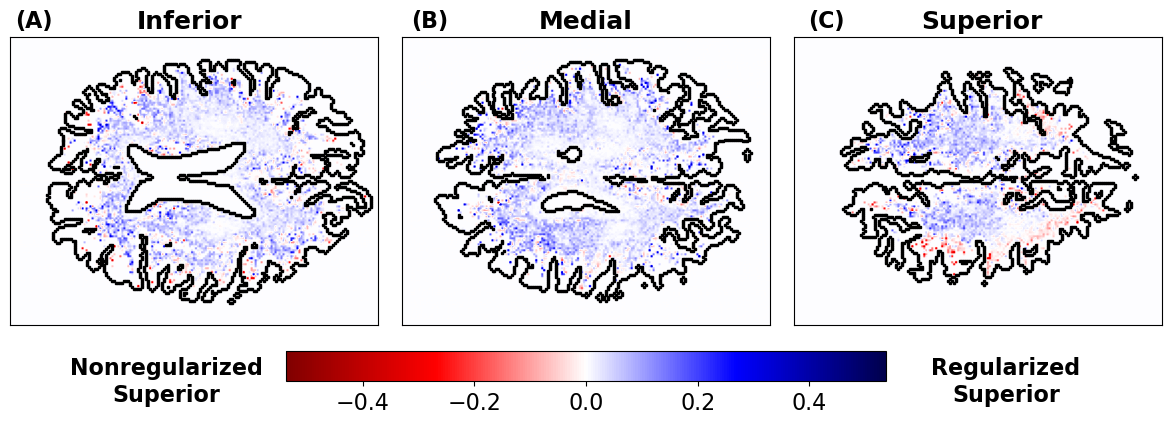

In [135]:
d1_RMSE_array = calc_RMSE(d1_p_est_mat, d1_strux_mat[1])
d1_RMSE_diff = d1_RMSE_array[2][0,:,:]**(1/2) - d1_RMSE_array[2][1,:,:]**(1/2)
d1_avgRMSE_diff = np.mean(d1_RMSE_diff[np.where(d1_RMSE_array[-1])])

d2_RMSE_array = calc_RMSE(d2_p_est_mat, d2_strux_mat[1])
d2_RMSE_diff = d2_RMSE_array[2][0,:,:]**(1/2) - d2_RMSE_array[2][1,:,:]**(1/2)
d2_avgRMSE_diff = np.mean(d2_RMSE_diff[np.where(d2_RMSE_array[-1])])

d3_RMSE_array = calc_RMSE(d3_p_est_mat, d3_strux_mat[1])
d3_RMSE_diff = d3_RMSE_array[2][0,:,:]**(1/2) - d3_RMSE_array[2][1,:,:]**(1/2)
d3_avgRMSE_diff = np.mean(d3_RMSE_diff[np.where(d3_RMSE_array[-1])])

overall_max = np.max(np.abs([d1_RMSE_diff, d2_RMSE_diff, d3_RMSE_diff]))

delta_txt = r'$\Delta$'
fig, ax = plt.subplots(1,3,figsize=(12,5),tight_layout=True)
plt.rc('font', size  = 20)
# fig.suptitle(f'{delta_txt}RMSE of MWF')
plt.rc('font', size  = 16)

pNLLS = ax[0].imshow(d1_RMSE_diff, cmap = 'seismic_r', vmin = -overall_max, vmax = overall_max)
# cbar = fig.colorbar(pNLLS, ax=ax[0], fraction=0.046, pad=0.04, location = 'bottom')
# ax[0].set_title(f'Average Change = {d1_avgRMSE_diff:0.5f}')
ax[0].tick_params(left = False, bottom = False, labelbottom = False, labelleft = False)
ax[0].plot(d1_outline_indices[1],d1_outline_indices[0], color = 'k', marker = 's', ls = '', markersize = 1.5)

pNLLS = ax[1].imshow(d2_RMSE_diff, cmap = 'seismic_r', vmin = -overall_max, vmax = overall_max)
# cbar = fig.colorbar(pNLLS, ax=ax[1], fraction=0.046, pad=0.04, location = 'bottom')
# ax[1].set_title(f'Average Change = {d2_avgRMSE_diff:0.5f}')
ax[1].tick_params(left = False, bottom = False, labelbottom = False, labelleft = False)
ax[1].plot(d2_outline_indices[1],d2_outline_indices[0], color = 'k', marker = 's', ls = '', markersize = 1.5)

pNLLS = ax[2].imshow(d3_RMSE_diff, cmap = 'seismic_r', vmin = -overall_max, vmax = overall_max)
# cbar = fig.colorbar(pNLLS, ax=ax[2], fraction=0.046, pad=0.04, location = 'bottom')
# ax[2].set_title(f'Average Change = {d3_avgRMSE_diff:0.5f}')
ax[2].tick_params(left = False, bottom = False, labelbottom = False, labelleft = False)
ax[2].plot(d3_outline_indices[1],d3_outline_indices[0], color = 'k', marker = 's', ls = '', markersize = 1.5)

cb_ax = fig.add_axes([0.25,0.1,0.5,.06])
fig.colorbar(pNLLS, orientation = 'horizontal', cax=cb_ax)

plt.rc('font', size = 16)
fig.text(0.04,0.82, '(A)', ha="center", va="center", color="black", weight = "bold")
fig.text(0.37,0.82, '(B)', ha="center", va="center", color="black", weight = "bold")
fig.text(0.70,0.82, '(C)', ha="center", va="center", color="black", weight = "bold")
# plt.rc('font', size = 18)
# fig.text(0.17,0.85,f'{d1_pat_tag}\nSNR = {d1_target_SNR}', weight = 'bold', ha="center", va="center")
# fig.text(0.50,0.85,f'{d2_pat_tag}\nSNR = {d2_target_SNR}', weight = 'bold', ha="center", va="center")
# fig.text(0.83,0.85,f'{d3_pat_tag}\nSNR = {d3_target_SNR}', weight = 'bold', ha="center", va="center")
plt.rc('font', size = 18)
fig.text(0.17,0.82,f'Inferior', weight = 'bold', ha="center", va="center")
fig.text(0.50,0.82,f'Medial', weight = 'bold', ha="center", va="center")
fig.text(0.83,0.82,f'Superior', weight = 'bold', ha="center", va="center")

print(f'{delta_txt}RMSE of MWF')
print(f'Average Change for {d1_pat_tag} at SNR {d1_SNR} = {d1_avgRMSE_diff:0.8f}')
print(f'Average Change for {d2_pat_tag} at SNR {d2_SNR} = {d2_avgRMSE_diff:0.8f}')
print(f'Average Change for {d3_pat_tag} at SNR {d3_SNR} = {d3_avgRMSE_diff:0.5f}')

plt.rc('font', size  = 16)
fig.text(0.15, 0.06,"Nonregularized\nSuperior", ha='center', weight = 'bold')
fig.text(0.85, 0.06,"Regularized\nSuperior", ha='center', weight = 'bold')


plt.show()

$\Delta$STD of MWF
Average Change for m79 at SNR 102.19146093033449 = 0.02224829
Average Change for m79 at SNR 102.19146093033449 = 0.02013149
Average Change for m79 at SNR 102.19146093033449 = 0.02070


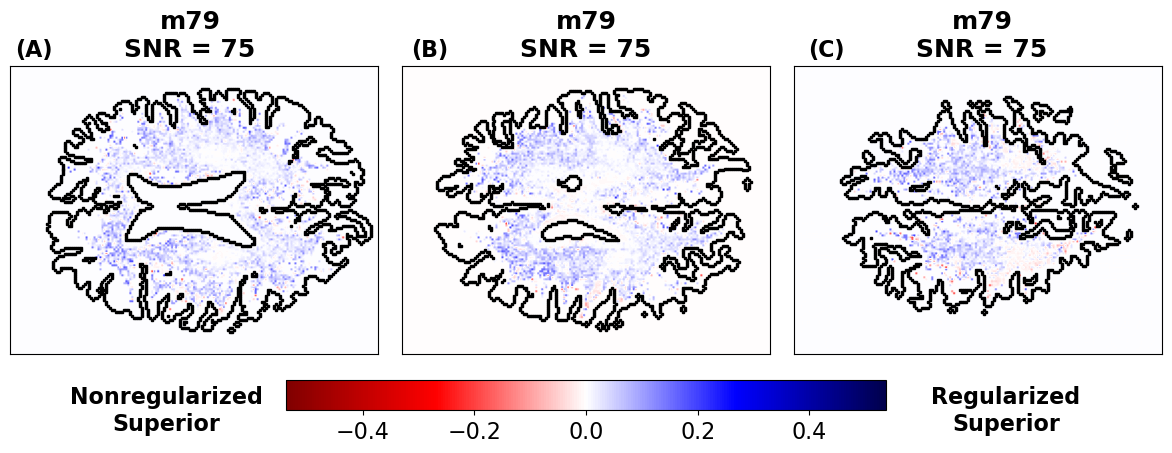

In [136]:
d1_RVAR_diff = d1_RMSE_array[1][0,:,:]**(1/2) - d1_RMSE_array[1][1,:,:]**(1/2)
d1_avgRVAR_diff = np.mean(d1_RVAR_diff[np.where(d1_RMSE_array[-1])])

d2_RVAR_diff = d2_RMSE_array[1][0,:,:]**(1/2) - d2_RMSE_array[1][1,:,:]**(1/2)
d2_avgRVAR_diff = np.mean(d2_RVAR_diff[np.where(d2_RMSE_array[-1])])

d3_RVAR_diff = d3_RMSE_array[1][0,:,:]**(1/2) - d3_RMSE_array[1][1,:,:]**(1/2)
d3_avgRVAR_diff = np.mean(d3_RVAR_diff[np.where(d3_RMSE_array[-1])])

overall_max = np.max(np.abs([d1_RMSE_diff, d2_RMSE_diff, d3_RMSE_diff]))

delta_txt = r'$\Delta$'
fig, ax = plt.subplots(1,3,figsize=(12,5),tight_layout=True)
plt.rc('font', size  = 20)
# fig.suptitle(f'{delta_txt}STD of MWF' )
plt.rc('font', size  = 16)

pNLLS = ax[0].imshow(d1_RVAR_diff, cmap = 'seismic_r', vmin = -overall_max, vmax = overall_max)
# cbar = fig.colorbar(pNLLS, ax=ax[0], fraction=0.046, pad=0.04, location = 'bottom')
# ax[0].set_title(f'Average Change = {d1_avgRVAR_diff:0.5f}')
ax[0].tick_params(left = False, bottom = False, labelbottom = False, labelleft = False)
ax[0].plot(d1_outline_indices[1],d1_outline_indices[0], color = 'k', marker = 's', ls = '', markersize = 1.5)

pNLLS = ax[1].imshow(d2_RVAR_diff, cmap = 'seismic_r', vmin = -overall_max, vmax = overall_max)
# cbar = fig.colorbar(pNLLS, ax=ax[1], fraction=0.046, pad=0.04, location = 'bottom')
# ax[1].set_title(f'Average Change = {d2_avgRVAR_diff:0.5f}')
ax[1].tick_params(left = False, bottom = False, labelbottom = False, labelleft = False)
ax[1].plot(d2_outline_indices[1],d2_outline_indices[0], color = 'k', marker = 's', ls = '', markersize = 1.5)

pNLLS = ax[2].imshow(d3_RVAR_diff, cmap = 'seismic_r', vmin = -overall_max, vmax = overall_max)
# cbar = fig.colorbar(pNLLS, ax=ax[2], fraction=0.046, pad=0.04, location = 'bottom')
# ax[2].set_title(f'Average Change = {d3_avgRVAR_diff:0.5f}')
ax[2].tick_params(left = False, bottom = False, labelbottom = False, labelleft = False)
ax[2].plot(d3_outline_indices[1],d3_outline_indices[0], color = 'k', marker = 's', ls = '', markersize = 1.5)

cb_ax = fig.add_axes([0.25,0.1,0.5,.06])
fig.colorbar(pNLLS, orientation = 'horizontal', cax=cb_ax)

plt.rc('font', size = 16)
fig.text(0.04,0.82, '(A)', ha="center", va="center", color="black", weight = "bold")
fig.text(0.37,0.82, '(B)', ha="center", va="center", color="black", weight = "bold")
fig.text(0.70,0.82, '(C)', ha="center", va="center", color="black", weight = "bold")
plt.rc('font', size = 18)
fig.text(0.17,0.85,f'{d1_pat_tag}\nSNR = {d1_target_SNR}', weight = 'bold', ha="center", va="center")
fig.text(0.50,0.85,f'{d2_pat_tag}\nSNR = {d2_target_SNR}', weight = 'bold', ha="center", va="center")
fig.text(0.83,0.85,f'{d3_pat_tag}\nSNR = {d3_target_SNR}', weight = 'bold', ha="center", va="center")

print(f'{delta_txt}STD of MWF')
print(f'Average Change for {d1_pat_tag} at SNR {d1_SNR} = {d1_avgRVAR_diff:0.8f}')
print(f'Average Change for {d2_pat_tag} at SNR {d2_SNR} = {d2_avgRVAR_diff:0.8f}')
print(f'Average Change for {d3_pat_tag} at SNR {d3_SNR} = {d3_avgRVAR_diff:0.5f}')

plt.rc('font', size  = 16)
fig.text(0.15, 0.06,"Nonregularized\nSuperior", ha='center', weight = 'bold')
fig.text(0.85, 0.06,"Regularized\nSuperior", ha='center', weight = 'bold')


plt.show()

$\Delta$|bias| of MWF
Average Change for m79 at SNR 102.19146093033449 = 0.01936580
Average Change for m79 at SNR 102.19146093033449 = 0.02746217
Average Change for m79 at SNR 102.19146093033449 = 0.01348


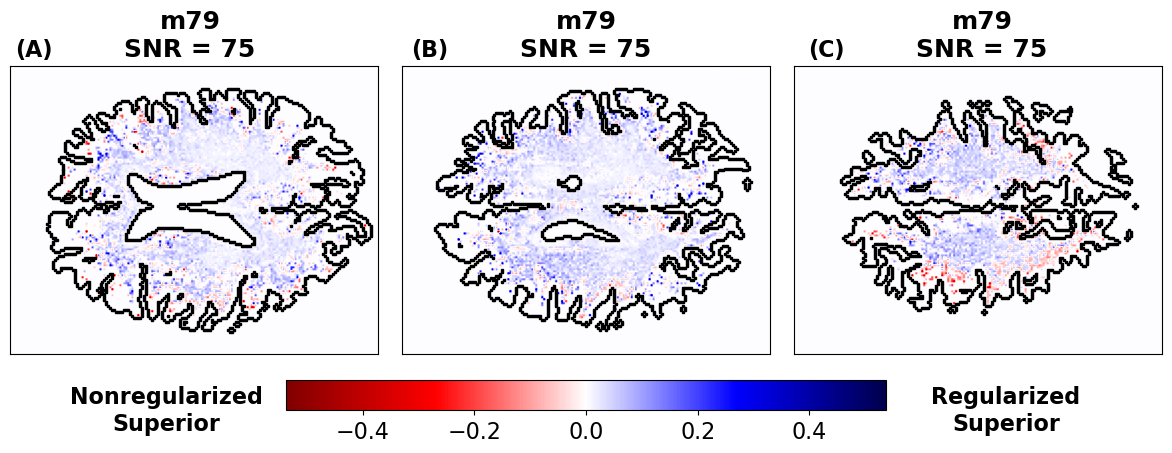

In [137]:
d1_RSQB_diff = d1_RMSE_array[0][0,:,:]**(1/2) - d1_RMSE_array[0][1,:,:]**(1/2)
d1_avgRSQB_diff = np.mean(d1_RSQB_diff[np.where(d1_RMSE_array[-1])])

d2_RSQB_diff = d2_RMSE_array[0][0,:,:]**(1/2) - d2_RMSE_array[0][1,:,:]**(1/2)
d2_avgRSQB_diff = np.mean(d2_RSQB_diff[np.where(d2_RMSE_array[-1])])

d3_RSQB_diff = d3_RMSE_array[0][0,:,:]**(1/2) - d3_RMSE_array[0][1,:,:]**(1/2)
d3_avgRSQB_diff = np.mean(d3_RSQB_diff[np.where(d3_RMSE_array[-1])])

overall_max = np.max(np.abs([d1_RMSE_diff, d2_RMSE_diff, d3_RMSE_diff]))

delta_txt = r'$\Delta$'
fig, ax = plt.subplots(1,3,figsize=(12,5),tight_layout=True)
plt.rc('font', size  = 20)
# fig.suptitle(f'{delta_txt}RSQB of MWF' )
plt.rc('font', size  = 16)

pNLLS = ax[0].imshow(d1_RSQB_diff, cmap = 'seismic_r', vmin = -overall_max, vmax = overall_max)
# cbar = fig.colorbar(pNLLS, ax=ax[0], fraction=0.046, pad=0.04, location = 'bottom')
# ax[0].set_title(f'Average Change = {d1_avgRSQB_diff:0.5f}')
ax[0].tick_params(left = False, bottom = False, labelbottom = False, labelleft = False)
ax[0].plot(d1_outline_indices[1],d1_outline_indices[0], color = 'k', marker = 's', ls = '', markersize = 1.5)

pNLLS = ax[1].imshow(d2_RSQB_diff, cmap = 'seismic_r', vmin = -overall_max, vmax = overall_max)
# cbar = fig.colorbar(pNLLS, ax=ax[1], fraction=0.046, pad=0.04, location = 'bottom')
# ax[1].set_title(f'Average Change = {d2_avgRSQB_diff:0.5f}')
ax[1].tick_params(left = False, bottom = False, labelbottom = False, labelleft = False)
ax[1].plot(d2_outline_indices[1],d2_outline_indices[0], color = 'k', marker = 's', ls = '', markersize = 1.5)

pNLLS = ax[2].imshow(d3_RSQB_diff, cmap = 'seismic_r', vmin = -overall_max, vmax = overall_max)
# cbar = fig.colorbar(pNLLS, ax=ax[2], fraction=0.046, pad=0.04, location = 'bottom')
# ax[2].set_title(f'Average Change = {d3_avgRSQB_diff:0.5f}')
ax[2].tick_params(left = False, bottom = False, labelbottom = False, labelleft = False)
ax[2].plot(d3_outline_indices[1],d3_outline_indices[0], color = 'k', marker = 's', ls = '', markersize = 1.5)

cb_ax = fig.add_axes([0.25,0.1,0.5,.06])
fig.colorbar(pNLLS, orientation = 'horizontal', cax=cb_ax)

plt.rc('font', size = 16)
fig.text(0.04,0.82, '(A)', ha="center", va="center", color="black", weight = "bold")
fig.text(0.37,0.82, '(B)', ha="center", va="center", color="black", weight = "bold")
fig.text(0.70,0.82, '(C)', ha="center", va="center", color="black", weight = "bold")
plt.rc('font', size = 18)
fig.text(0.17,0.85,f'{d1_pat_tag}\nSNR = {d1_target_SNR}', weight = 'bold', ha="center", va="center")
fig.text(0.50,0.85,f'{d2_pat_tag}\nSNR = {d2_target_SNR}', weight = 'bold', ha="center", va="center")
fig.text(0.83,0.85,f'{d3_pat_tag}\nSNR = {d3_target_SNR}', weight = 'bold', ha="center", va="center")
# plt.rc('font', size = 18)
# fig.text(0.17,0.82,f'Inferior', weight = 'bold', ha="center", va="center")
# fig.text(0.50,0.82,f'Medial', weight = 'bold', ha="center", va="center")
# fig.text(0.83,0.82,f'Superior', weight = 'bold', ha="center", va="center")

print(f'{delta_txt}|bias| of MWF')
print(f'Average Change for {d1_pat_tag} at SNR {d1_SNR} = {d1_avgRSQB_diff:0.8f}')
print(f'Average Change for {d2_pat_tag} at SNR {d2_SNR} = {d2_avgRSQB_diff:0.8f}')
print(f'Average Change for {d3_pat_tag} at SNR {d3_SNR} = {d3_avgRSQB_diff:0.5f}')

plt.rc('font', size  = 16)
fig.text(0.15, 0.06,"Nonregularized\nSuperior", ha='center', weight = 'bold')
fig.text(0.85, 0.06,"Regularized\nSuperior", ha='center', weight = 'bold')

plt.show()